In [4]:
import os
os.environ["WANDB_MODE"] = "disabled"


In [5]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [6]:
from torch.utils.data import Dataset
import pandas as pd

class TextToTextDataset(Dataset):
    def __init__(self, csv_file, tokenizer):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_text = self.data.iloc[idx]['Input_text']
        output_text = self.data.iloc[idx]['Output_text']

        input_tokens = self.tokenizer(input_text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        output_tokens = self.tokenizer(output_text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')

        return {
            'input_ids': input_tokens['input_ids'].squeeze(),
            'attention_mask': input_tokens['attention_mask'].squeeze(),
            'labels': output_tokens['input_ids'].squeeze()
        }

In [7]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

# Load the tokenizer and model
model_checkpoint = "t5-small"  # You can use any other seq2seq model like 'bart-base'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [8]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")


count_parameters(model)

Total parameters: 60,506,624
Trainable parameters: 60,506,624
Percentage of trainable parameters: 100.00%


In [9]:
for name, param in model.named_parameters():
    print(f"{name}: {'trainable' if param.requires_grad else 'frozen'}")

shared.weight: trainable
encoder.block.0.layer.0.SelfAttention.q.weight: trainable
encoder.block.0.layer.0.SelfAttention.k.weight: trainable
encoder.block.0.layer.0.SelfAttention.v.weight: trainable
encoder.block.0.layer.0.SelfAttention.o.weight: trainable
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight: trainable
encoder.block.0.layer.0.layer_norm.weight: trainable
encoder.block.0.layer.1.DenseReluDense.wi.weight: trainable
encoder.block.0.layer.1.DenseReluDense.wo.weight: trainable
encoder.block.0.layer.1.layer_norm.weight: trainable
encoder.block.1.layer.0.SelfAttention.q.weight: trainable
encoder.block.1.layer.0.SelfAttention.k.weight: trainable
encoder.block.1.layer.0.SelfAttention.v.weight: trainable
encoder.block.1.layer.0.SelfAttention.o.weight: trainable
encoder.block.1.layer.0.layer_norm.weight: trainable
encoder.block.1.layer.1.DenseReluDense.wi.weight: trainable
encoder.block.1.layer.1.DenseReluDense.wo.weight: trainable
encoder.block.1.layer.1.layer_no

In [10]:
trainable_params = [p for p in model.parameters() if p.requires_grad]
print(f"Number of trainable parameters in the optimizer: {len(trainable_params)}")

Number of trainable parameters in the optimizer: 131


In [11]:
# Load your dataset
train_dataset = TextToTextDataset("navigation_dataset_Training.csv", tokenizer)
eval_dataset = TextToTextDataset("navigation_dataset_Validation.csv", tokenizer)

# Define the data collator (handles padding and batching)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [12]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=25,
    predict_with_generate=True,
    push_to_hub=False
)


c:\Users\jagad\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
from torch.optim import AdamW

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)


In [14]:
# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, None)
)

trainer.train()


C:\Users\jagad\AppData\Local\Temp\ipykernel_24872\3945335570.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


  0%|          | 0/30950 [00:00<?, ?it/s]

c:\Users\jagad\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\data\data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


{'loss': 1.2698, 'grad_norm': 0.45117443799972534, 'learning_rate': 1.967689822294023e-05, 'epoch': 0.4}
{'loss': 0.0268, 'grad_norm': 0.3303474187850952, 'learning_rate': 1.9353796445880454e-05, 'epoch': 0.81}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.0055312528274953365, 'eval_runtime': 11.7374, 'eval_samples_per_second': 407.245, 'eval_steps_per_second': 25.474, 'epoch': 1.0}
{'loss': 0.0128, 'grad_norm': 0.17623844742774963, 'learning_rate': 1.903069466882068e-05, 'epoch': 1.21}
{'loss': 0.0071, 'grad_norm': 0.2129611074924469, 'learning_rate': 1.8707592891760907e-05, 'epoch': 1.62}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.00338340294547379, 'eval_runtime': 11.8615, 'eval_samples_per_second': 402.986, 'eval_steps_per_second': 25.208, 'epoch': 2.0}
{'loss': 0.0041, 'grad_norm': 0.11927991360425949, 'learning_rate': 1.8384491114701135e-05, 'epoch': 2.02}
{'loss': 0.0028, 'grad_norm': 0.02084704302251339, 'learning_rate': 1.806138933764136e-05, 'epoch': 2.42}
{'loss': 0.0018, 'grad_norm': 0.1608385294675827, 'learning_rate': 1.7738287560581584e-05, 'epoch': 2.83}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.004205809906125069, 'eval_runtime': 11.8841, 'eval_samples_per_second': 402.217, 'eval_steps_per_second': 25.16, 'epoch': 3.0}
{'loss': 0.0014, 'grad_norm': 0.17630285024642944, 'learning_rate': 1.741518578352181e-05, 'epoch': 3.23}
{'loss': 0.0011, 'grad_norm': 0.020115606486797333, 'learning_rate': 1.7092084006462036e-05, 'epoch': 3.63}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.0037382980808615685, 'eval_runtime': 11.8912, 'eval_samples_per_second': 401.977, 'eval_steps_per_second': 25.145, 'epoch': 4.0}
{'loss': 0.001, 'grad_norm': 0.042930636554956436, 'learning_rate': 1.6768982229402264e-05, 'epoch': 4.04}
{'loss': 0.0007, 'grad_norm': 0.02651054784655571, 'learning_rate': 1.644588045234249e-05, 'epoch': 4.44}
{'loss': 0.0006, 'grad_norm': 0.22447675466537476, 'learning_rate': 1.6122778675282717e-05, 'epoch': 4.85}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.0050986530259251595, 'eval_runtime': 11.8725, 'eval_samples_per_second': 402.612, 'eval_steps_per_second': 25.184, 'epoch': 5.0}
{'loss': 0.0005, 'grad_norm': 0.00415400043129921, 'learning_rate': 1.579967689822294e-05, 'epoch': 5.25}
{'loss': 0.0004, 'grad_norm': 0.0014863454271107912, 'learning_rate': 1.547657512116317e-05, 'epoch': 5.65}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.00497994851320982, 'eval_runtime': 11.8912, 'eval_samples_per_second': 401.979, 'eval_steps_per_second': 25.145, 'epoch': 6.0}
{'loss': 0.0004, 'grad_norm': 0.0006304868147708476, 'learning_rate': 1.5153473344103394e-05, 'epoch': 6.06}
{'loss': 0.0003, 'grad_norm': 0.22143028676509857, 'learning_rate': 1.483037156704362e-05, 'epoch': 6.46}
{'loss': 0.0003, 'grad_norm': 0.0012106028152629733, 'learning_rate': 1.4507269789983846e-05, 'epoch': 6.87}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.005570524837821722, 'eval_runtime': 11.8919, 'eval_samples_per_second': 401.956, 'eval_steps_per_second': 25.143, 'epoch': 7.0}
{'loss': 0.0002, 'grad_norm': 0.01337767019867897, 'learning_rate': 1.4184168012924074e-05, 'epoch': 7.27}
{'loss': 0.0002, 'grad_norm': 0.0034649271983653307, 'learning_rate': 1.3861066235864299e-05, 'epoch': 7.67}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.00638899439945817, 'eval_runtime': 11.9174, 'eval_samples_per_second': 401.093, 'eval_steps_per_second': 25.089, 'epoch': 8.0}
{'loss': 0.0002, 'grad_norm': 0.002779684728011489, 'learning_rate': 1.3537964458804525e-05, 'epoch': 8.08}
{'loss': 0.0002, 'grad_norm': 0.0011492164339870214, 'learning_rate': 1.3214862681744751e-05, 'epoch': 8.48}
{'loss': 0.0002, 'grad_norm': 0.0022158417850732803, 'learning_rate': 1.2891760904684977e-05, 'epoch': 8.89}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.0060611292719841, 'eval_runtime': 11.9109, 'eval_samples_per_second': 401.313, 'eval_steps_per_second': 25.103, 'epoch': 9.0}
{'loss': 0.0002, 'grad_norm': 0.0008223108015954494, 'learning_rate': 1.2568659127625202e-05, 'epoch': 9.29}
{'loss': 0.0001, 'grad_norm': 0.00015292565512936562, 'learning_rate': 1.224555735056543e-05, 'epoch': 9.69}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.00596174830570817, 'eval_runtime': 11.911, 'eval_samples_per_second': 401.311, 'eval_steps_per_second': 25.103, 'epoch': 10.0}
{'loss': 0.0002, 'grad_norm': 0.00016237558156717569, 'learning_rate': 1.1922455573505656e-05, 'epoch': 10.1}
{'loss': 0.0001, 'grad_norm': 0.000322429375955835, 'learning_rate': 1.1599353796445882e-05, 'epoch': 10.5}
{'loss': 0.0002, 'grad_norm': 0.0033702212385833263, 'learning_rate': 1.1276252019386107e-05, 'epoch': 10.9}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.006853950675576925, 'eval_runtime': 11.9304, 'eval_samples_per_second': 400.659, 'eval_steps_per_second': 25.062, 'epoch': 11.0}
{'loss': 0.0001, 'grad_norm': 0.0016252694185823202, 'learning_rate': 1.0953150242326333e-05, 'epoch': 11.31}
{'loss': 0.0001, 'grad_norm': 0.0011816483456641436, 'learning_rate': 1.0630048465266561e-05, 'epoch': 11.71}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.006823114585131407, 'eval_runtime': 11.8653, 'eval_samples_per_second': 402.857, 'eval_steps_per_second': 25.2, 'epoch': 12.0}
{'loss': 0.0002, 'grad_norm': 0.0003077418659813702, 'learning_rate': 1.0306946688206787e-05, 'epoch': 12.12}
{'loss': 0.0001, 'grad_norm': 0.00014075452054385096, 'learning_rate': 9.983844911147012e-06, 'epoch': 12.52}
{'loss': 0.0001, 'grad_norm': 0.0003951510589104146, 'learning_rate': 9.660743134087238e-06, 'epoch': 12.92}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.0073179928585886955, 'eval_runtime': 11.8599, 'eval_samples_per_second': 403.037, 'eval_steps_per_second': 25.211, 'epoch': 13.0}
{'loss': 0.0001, 'grad_norm': 0.0001037792899296619, 'learning_rate': 9.337641357027464e-06, 'epoch': 13.33}
{'loss': 0.0001, 'grad_norm': 0.000276662758551538, 'learning_rate': 9.01453957996769e-06, 'epoch': 13.73}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.007768251467496157, 'eval_runtime': 11.8526, 'eval_samples_per_second': 403.288, 'eval_steps_per_second': 25.227, 'epoch': 14.0}
{'loss': 0.0001, 'grad_norm': 0.00037027086364105344, 'learning_rate': 8.691437802907917e-06, 'epoch': 14.14}
{'loss': 0.0001, 'grad_norm': 0.0028295728843659163, 'learning_rate': 8.368336025848143e-06, 'epoch': 14.54}
{'loss': 0.0001, 'grad_norm': 0.00013552725431509316, 'learning_rate': 8.04523424878837e-06, 'epoch': 14.94}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.007453940808773041, 'eval_runtime': 11.9038, 'eval_samples_per_second': 401.551, 'eval_steps_per_second': 25.118, 'epoch': 15.0}
{'loss': 0.0001, 'grad_norm': 0.00028933401335962117, 'learning_rate': 7.722132471728596e-06, 'epoch': 15.35}
{'loss': 0.0001, 'grad_norm': 7.763887697365135e-05, 'learning_rate': 7.399030694668822e-06, 'epoch': 15.75}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.007528791669756174, 'eval_runtime': 11.894, 'eval_samples_per_second': 401.884, 'eval_steps_per_second': 25.139, 'epoch': 16.0}
{'loss': 0.0001, 'grad_norm': 0.0002238717133877799, 'learning_rate': 7.075928917609047e-06, 'epoch': 16.16}
{'loss': 0.0001, 'grad_norm': 0.0019450685940682888, 'learning_rate': 6.752827140549274e-06, 'epoch': 16.56}
{'loss': 0.0001, 'grad_norm': 0.00035984397982247174, 'learning_rate': 6.4297253634895e-06, 'epoch': 16.96}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.00789909902960062, 'eval_runtime': 11.9016, 'eval_samples_per_second': 401.626, 'eval_steps_per_second': 25.123, 'epoch': 17.0}
{'loss': 0.0001, 'grad_norm': 0.001967102289199829, 'learning_rate': 6.106623586429726e-06, 'epoch': 17.37}
{'loss': 0.0, 'grad_norm': 0.0023096182849258184, 'learning_rate': 5.783521809369952e-06, 'epoch': 17.77}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.00822523795068264, 'eval_runtime': 11.882, 'eval_samples_per_second': 402.288, 'eval_steps_per_second': 25.164, 'epoch': 18.0}
{'loss': 0.0, 'grad_norm': 0.0019294448429718614, 'learning_rate': 5.4604200323101785e-06, 'epoch': 18.17}
{'loss': 0.0001, 'grad_norm': 0.0001710093201836571, 'learning_rate': 5.137318255250404e-06, 'epoch': 18.58}
{'loss': 0.0, 'grad_norm': 0.0002689789980649948, 'learning_rate': 4.81421647819063e-06, 'epoch': 18.98}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.008452478796243668, 'eval_runtime': 11.8445, 'eval_samples_per_second': 403.564, 'eval_steps_per_second': 25.244, 'epoch': 19.0}
{'loss': 0.0001, 'grad_norm': 0.0004054356541018933, 'learning_rate': 4.491114701130856e-06, 'epoch': 19.39}
{'loss': 0.0, 'grad_norm': 0.00016709706687834114, 'learning_rate': 4.168012924071083e-06, 'epoch': 19.79}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.00819813646376133, 'eval_runtime': 11.8547, 'eval_samples_per_second': 403.215, 'eval_steps_per_second': 25.222, 'epoch': 20.0}
{'loss': 0.0, 'grad_norm': 7.678167457925156e-05, 'learning_rate': 3.844911147011309e-06, 'epoch': 20.19}
{'loss': 0.0, 'grad_norm': 0.002581005683168769, 'learning_rate': 3.5218093699515347e-06, 'epoch': 20.6}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.008427100256085396, 'eval_runtime': 11.9137, 'eval_samples_per_second': 401.218, 'eval_steps_per_second': 25.097, 'epoch': 21.0}
{'loss': 0.0, 'grad_norm': 7.033775909803808e-05, 'learning_rate': 3.198707592891761e-06, 'epoch': 21.0}
{'loss': 0.0, 'grad_norm': 0.00016779301222413778, 'learning_rate': 2.875605815831987e-06, 'epoch': 21.41}
{'loss': 0.0, 'grad_norm': 0.0024612112902104855, 'learning_rate': 2.5525040387722134e-06, 'epoch': 21.81}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.008440929464995861, 'eval_runtime': 11.8817, 'eval_samples_per_second': 402.298, 'eval_steps_per_second': 25.165, 'epoch': 22.0}
{'loss': 0.0, 'grad_norm': 0.00012277350469958037, 'learning_rate': 2.2294022617124397e-06, 'epoch': 22.21}
{'loss': 0.0001, 'grad_norm': 0.0004748845240101218, 'learning_rate': 1.906300484652666e-06, 'epoch': 22.62}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.00814598985016346, 'eval_runtime': 11.8848, 'eval_samples_per_second': 402.196, 'eval_steps_per_second': 25.158, 'epoch': 23.0}
{'loss': 0.0, 'grad_norm': 0.00026688017533160746, 'learning_rate': 1.583198707592892e-06, 'epoch': 23.02}
{'loss': 0.0, 'grad_norm': 0.00010312227095710114, 'learning_rate': 1.2600969305331182e-06, 'epoch': 23.42}
{'loss': 0.0001, 'grad_norm': 0.002879653126001358, 'learning_rate': 9.369951534733441e-07, 'epoch': 23.83}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.008168320171535015, 'eval_runtime': 11.8833, 'eval_samples_per_second': 402.244, 'eval_steps_per_second': 25.161, 'epoch': 24.0}
{'loss': 0.0, 'grad_norm': 0.0002772304869722575, 'learning_rate': 6.138933764135703e-07, 'epoch': 24.23}
{'loss': 0.0, 'grad_norm': 0.00011525063018780202, 'learning_rate': 2.9079159935379645e-07, 'epoch': 24.64}


  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.008144055493175983, 'eval_runtime': 12.0367, 'eval_samples_per_second': 397.118, 'eval_steps_per_second': 24.841, 'epoch': 25.0}
{'train_runtime': 4577.2072, 'train_samples_per_second': 108.145, 'train_steps_per_second': 6.762, 'train_loss': 0.021580826457926885, 'epoch': 25.0}


TrainOutput(global_step=30950, training_loss=0.021580826457926885, metrics={'train_runtime': 4577.2072, 'train_samples_per_second': 108.145, 'train_steps_per_second': 6.762, 'total_flos': 1.674854793216e+16, 'train_loss': 0.021580826457926885, 'epoch': 25.0})

Plot saved at /content/results_finetune_entire_T5/train_val__loss_graphs\training_validation_loss.png


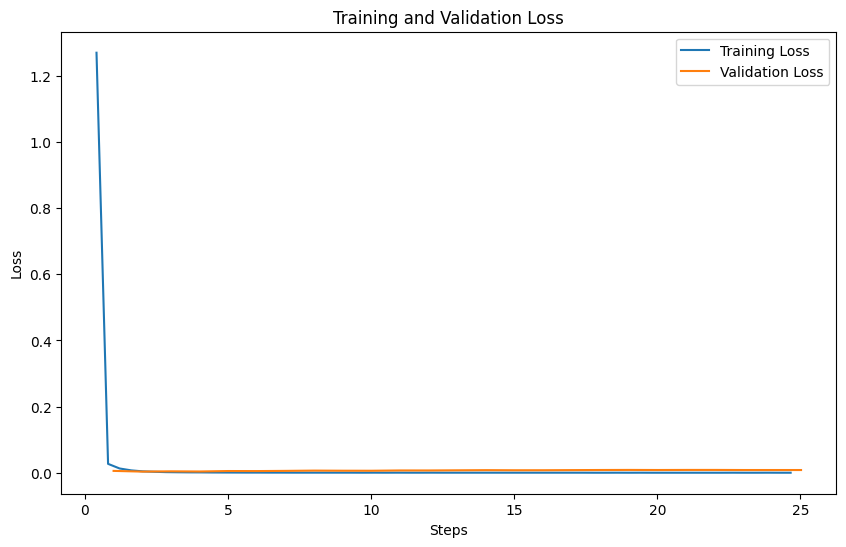

In [19]:
import os
import matplotlib.pyplot as plt

save_dir = "/content/results_finetune_entire_T5/train_val__loss_graphs"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Retrieve the training logs
logs = trainer.state.log_history

# Extract training and validation loss values
train_loss = [log['loss'] for log in logs if 'loss' in log]
train_steps = [log['step'] for log in logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
eval_steps = [log['step'] for log in logs if 'eval_loss' in log]

# Calculate epochs based on the step and total steps per epoch
steps_per_epoch = len(train_dataset) // trainer.args.per_device_train_batch_size
train_epochs = [step / steps_per_epoch for step in train_steps]
eval_epochs = [step / steps_per_epoch for step in eval_steps]

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_loss, label='Training Loss')
if eval_loss:
    plt.plot(eval_epochs, eval_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Save the plot to the specified directory
plot_path = os.path.join(save_dir, "training_validation_loss.png")
plt.savefig(plot_path)
print(f"Plot saved at {plot_path}")

plt.show()

In [20]:
# Evaluation function
def compute_accuracies(model, tokenizer, eval_dataset, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    dataloader = DataLoader(eval_dataset, batch_size=batch_size)
    sequence_correct = 0
    total_positions = 0
    position_correct = 0
    total_sequences = 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels']

            outputs = model.generate(
                input_ids,
                max_length=128,
                pad_token_id=tokenizer.pad_token_id
            )

            predictions = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
            true_labels = [tokenizer.decode(label[label != -100], skip_special_tokens=True) for label in labels]

            for pred, true in zip(predictions, true_labels):
                # Split by semicolon and strip whitespace
                pred_colors = [color.strip() for color in pred.split(';')]
                true_colors = [color.strip() for color in true.split(';')]

                if pred_colors == true_colors:
                    sequence_correct += 1
                total_sequences += 1

                min_len = min(len(pred_colors), len(true_colors))
                for i in range(min_len):
                    if pred_colors[i] == true_colors[i]:
                        position_correct += 1
                total_positions += len(true_colors)

    sequence_accuracy = sequence_correct / total_sequences
    position_accuracy = position_correct / total_positions

    return {
        'sequence_accuracy': sequence_accuracy,
        'position_accuracy': position_accuracy,
        'total_sequences': total_sequences,
        'total_positions': total_positions
    }

In [21]:
# Run evaluation
results = compute_accuracies(model, tokenizer, eval_dataset)
print(f"Sequence Accuracy: {results['sequence_accuracy']:.4f}")
print(f"Position Accuracy: {results['position_accuracy']:.4f}")
print(f"Total sequences evaluated: {results['total_sequences']}")
print(f"Total positions evaluated: {results['total_positions']}")

100%|██████████| 299/299 [00:23<00:00, 12.58it/s]

Sequence Accuracy: 0.9498
Position Accuracy: 0.9735
Total sequences evaluated: 4780
Total positions evaluated: 22620


In [22]:
# Example of generating output for a single input

model_path = "./results/checkpoint-30950"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

def generate_output(input_text):
    # Move model to the same device as the input
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)

    # Tokenize the input and move the inputs to the correct device
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding='max_length', max_length=128).to(device)

    # Make sure the model is also on the same device
    model.to(device)

    # Generate the output sequence
    output = model.generate(inputs['input_ids'], max_length=128)

    # Decode the generated tokens to text
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Test the model with a sample input
sample_input = "Before going to purple battery, start your task at green battery and make sure to visit blue battery along the way. Then go to the red battery, and wrap up at the orange battery. Just give me color order in this way; Go to [color1], Go to [color2]"
generated_output = generate_output(sample_input)
print(f"Input: {sample_input}")
print(f"Output: {generated_output}")


cuda
Input: Before going to purple battery, start your task at green battery and make sure to visit blue battery along the way. Then go to the red battery, and wrap up at the orange battery. Just give me color order in this way; Go to [color1], Go to [color2]
Output: green; blue; red; orange; color
